In [1]:
import time
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q -o chest-xray-pneumonia.zip

Mounted at /content/drive
100% 2.29G/2.29G [00:20<00:00, 217MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s]


In [4]:
random_seed = 123
batch_size = 512
num_epochs = 10
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [5]:
num_classes = 2
learning_rate = 0.1

### LeNet

In [11]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([            
    torchvision.transforms.Resize((32, 32)), 
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train',
                                     transform=train_transforms
                                     )

test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', 
                                    transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([512, 3, 32, 32])
Image label dimensions: torch.Size([512])


In [12]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1 #1 colour channel
        else:
            in_channels = 3 #3 colour channels

        self.features = torch.nn.Sequential(
            #extracting the features
            torch.nn.Conv2d(in_channels, 6, kernel_size=5), #1st convolutional layer, 6 feature maps ouput, 5x5 kernal (feature map size)
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2), #take the max value - reduces size to 2x2
            torch.nn.Conv2d(6, 16, kernel_size=5), #2nd convolutional layer, 6 features input, 16 feature maps output, 5x5 kernal
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential( #fully connected layer - classification layer
            torch.nn.Linear(16*5*5, 120), #output = 120 (16 input, 5x5 kernal)
            torch.nn.Tanh(),
            #slide 16 introduction to CNN
            torch.nn.Linear(120, 84), #6th layer
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes), #output layer
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) #convert to single dimension
        logits = self.classifier(x) #classification
        return logits

In [16]:
model = LeNet5(grayscale=False, 
               num_classes=2)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [17]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
#loss computed for each batch
#weights updated for each batch

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad() #dont keep computation graph in memory
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step() #update model parameters after each batch
        
        ### LOGGING
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/011 | Cost: 0.7385
Epoch: 001/010 training accuracy: 74.29%
Time elapsed: 3.86 min
Epoch: 002/010 | Batch 000/011 | Cost: 0.5514
Epoch: 002/010 training accuracy: 74.23%
Time elapsed: 7.57 min
Epoch: 003/010 | Batch 000/011 | Cost: 0.5176
Epoch: 003/010 training accuracy: 73.77%
Time elapsed: 11.31 min
Epoch: 004/010 | Batch 000/011 | Cost: 0.4861
Epoch: 004/010 training accuracy: 86.85%
Time elapsed: 15.02 min
Epoch: 005/010 | Batch 000/011 | Cost: 0.3520
Epoch: 005/010 training accuracy: 86.64%
Time elapsed: 18.76 min
Epoch: 006/010 | Batch 000/011 | Cost: 0.3517
Epoch: 006/010 training accuracy: 83.09%
Time elapsed: 22.48 min
Epoch: 007/010 | Batch 000/011 | Cost: 0.3569
Epoch: 007/010 training accuracy: 88.00%
Time elapsed: 26.41 min
Epoch: 008/010 | Batch 000/011 | Cost: 0.2747
Epoch: 008/010 training accuracy: 89.23%
Time elapsed: 30.15 min
Epoch: 009/010 | Batch 000/011 | Cost: 0.2345
Epoch: 009/010 training accuracy: 92.68%
Time elapsed: 33.89 min
Epo

In [18]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 66.51%


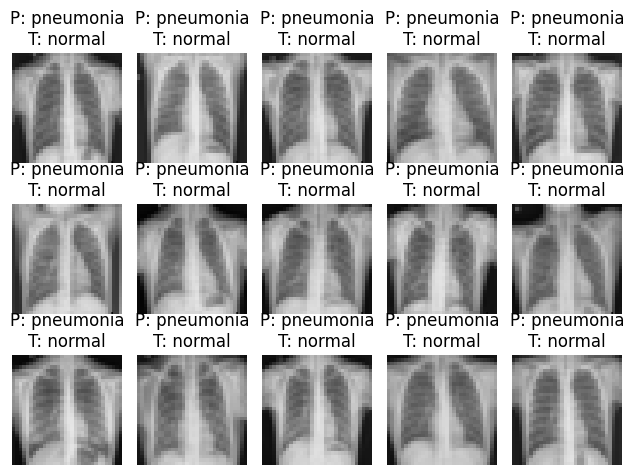

In [19]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'normal',
              1: 'pneumonia',
              }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

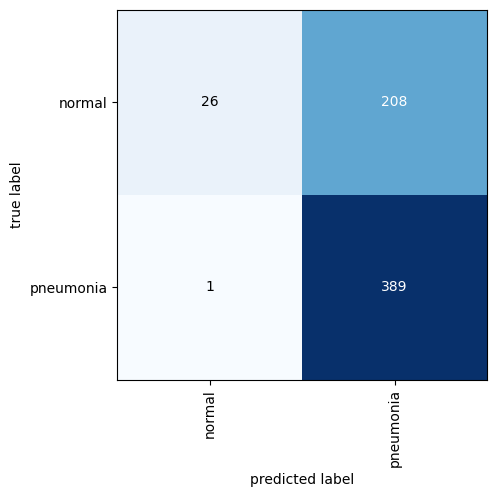

In [20]:
import matplotlib.pyplot as plt

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Accuracy on the test set: 66.51%
Precision: 0.65, Recall: 1.00, F1 score: 0.79


### ResNet

In [30]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),           
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train',
                                     transform=train_transforms
                                     )

test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', 
                                    transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([512, 3, 32, 32])
Image label dimensions: torch.Size([512])


In [10]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
#1st residual block 
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3, 
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4, 
                                out_channels=3,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(3)
        )
#2nd residual block        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=3,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(3)
        )

#Fully connected classification layer
               
        self.linear_1 = torch.nn.Linear(3*32*32, num_classes)

        
    def forward(self, x):
        
#1st residual block -1st skip connection
        
        shortcut = x
        x = self.block_1(x)
        x = torch.nn.functional.relu(x + shortcut)
        
#2nd residual block -2nd skip connection

        shortcut = x
        x = self.block_2(x)
        x = torch.nn.functional.relu(x + shortcut)
        
#Fully connected

        logits = self.linear_1(x.view(-1,  3*32*32))
        return logits


In [11]:
model = ConvNet(num_classes=2) 

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [12]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        logits = model(features)
        cost = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad() 
        
        cost.backward()
      
        optimizer.step() 
        
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() 
    with torch.set_grad_enabled(False): 
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/011 | Cost: 0.7312
Epoch: 001/010 training accuracy: 58.53%
Time elapsed: 4.03 min
Epoch: 002/010 | Batch 000/011 | Cost: 0.5612
Epoch: 002/010 training accuracy: 36.25%
Time elapsed: 7.92 min
Epoch: 003/010 | Batch 000/011 | Cost: 0.5902
Epoch: 003/010 training accuracy: 73.29%
Time elapsed: 11.80 min
Epoch: 004/010 | Batch 000/011 | Cost: 0.5715
Epoch: 004/010 training accuracy: 74.35%
Time elapsed: 15.83 min
Epoch: 005/010 | Batch 000/011 | Cost: 0.5836
Epoch: 005/010 training accuracy: 74.29%
Time elapsed: 19.67 min
Epoch: 006/010 | Batch 000/011 | Cost: 0.5448
Epoch: 006/010 training accuracy: 74.27%
Time elapsed: 23.54 min
Epoch: 007/010 | Batch 000/011 | Cost: 0.5239
Epoch: 007/010 training accuracy: 74.33%
Time elapsed: 27.39 min
Epoch: 008/010 | Batch 000/011 | Cost: 0.5872
Epoch: 008/010 training accuracy: 74.33%
Time elapsed: 31.31 min
Epoch: 009/010 | Batch 000/011 | Cost: 0.5582
Epoch: 009/010 training accuracy: 74.31%
Time elapsed: 35.17 min
Epo

In [13]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 62.50%


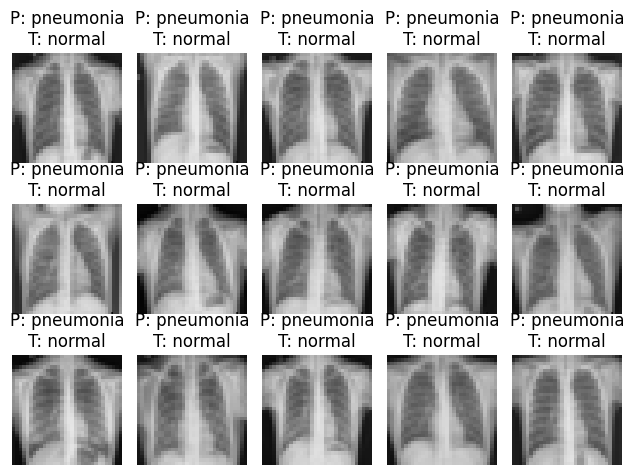

In [14]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'normal',
              1: 'pneumonia',
              }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

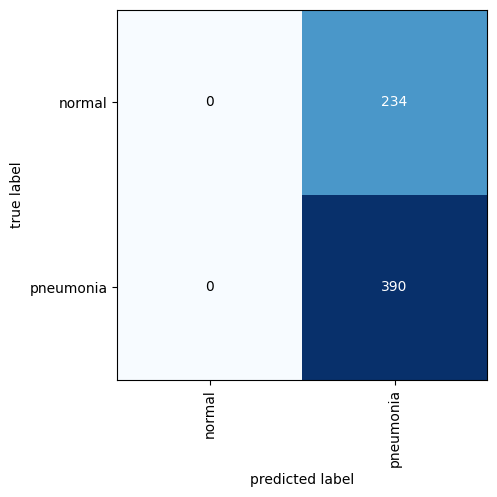

In [15]:
import matplotlib.pyplot as plt

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = []
predicted_labels = []
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")


Accuracy on the test set: 62.50%
Precision: 0.62, Recall: 1.00, F1 score: 0.77


### AlexNet 

In [6]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([            
    torchvision.transforms.Resize((32, 32)), 
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='/content/chest_xray/train',
                                     transform=train_transforms
                                     )

test_dataset = datasets.ImageFolder(root='/content/chest_xray/test', 
                                    transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([512, 3, 32, 32])
Image label dimensions: torch.Size([512])


In [7]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layers = torch.nn.Sequential(
                torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(32), 
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Flatten(),
                torch.nn.Linear(4096, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(0.1, inplace=True),
                torch.nn.Dropout(0.5),
                #
                torch.nn.Linear(128, num_classes),
                )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [8]:
model = ConvNet(num_classes=2)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [9]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        logits = model(features)
        cost = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad() 
        
        cost.backward()
        
        optimizer.step() 
        
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() 
    with torch.set_grad_enabled(False): 
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/011 | Cost: 0.7128
Epoch: 001/010 training accuracy: 74.31%
Time elapsed: 3.74 min
Epoch: 002/010 | Batch 000/011 | Cost: 0.0729
Epoch: 002/010 training accuracy: 96.38%
Time elapsed: 7.46 min
Epoch: 003/010 | Batch 000/011 | Cost: 0.0534
Epoch: 003/010 training accuracy: 93.52%
Time elapsed: 11.28 min
Epoch: 004/010 | Batch 000/011 | Cost: 0.1058
Epoch: 004/010 training accuracy: 96.22%
Time elapsed: 14.96 min
Epoch: 005/010 | Batch 000/011 | Cost: 0.0480
Epoch: 005/010 training accuracy: 98.37%
Time elapsed: 18.70 min
Epoch: 006/010 | Batch 000/011 | Cost: 0.0403
Epoch: 006/010 training accuracy: 98.56%
Time elapsed: 22.39 min
Epoch: 007/010 | Batch 000/011 | Cost: 0.0508
Epoch: 007/010 training accuracy: 99.04%
Time elapsed: 26.12 min
Epoch: 008/010 | Batch 000/011 | Cost: 0.0270
Epoch: 008/010 training accuracy: 99.08%
Time elapsed: 29.89 min
Epoch: 009/010 | Batch 000/011 | Cost: 0.0379
Epoch: 009/010 training accuracy: 98.89%
Time elapsed: 33.58 min
Epo

In [10]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 69.07%


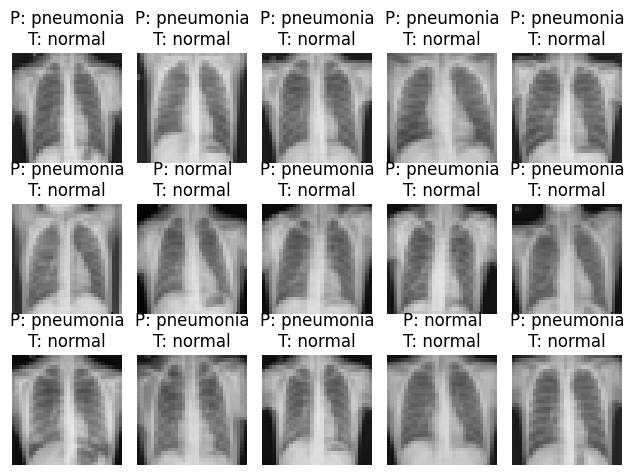

In [11]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'normal',
              1: 'pneumonia',
              }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

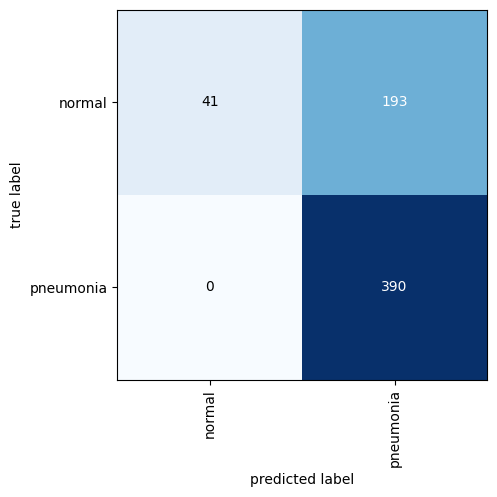

In [12]:
import matplotlib.pyplot as plt

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = []
predicted_labels = []
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")


Accuracy on the test set: 69.07%
Precision: 0.67, Recall: 1.00, F1 score: 0.80
